In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


We only have one rep for ERP29. Code breaks without a second rep, so I'm faking it by feading rep1 twice.

In [3]:
EPR1_fn = '../data/ERP29_rep1detailed.txt'
ERR2_fn = '../data/ERP29_rep2detailed.txt'

AXR1_fn = '../data/ATXN2_rep2detailed.txt'
AXR2_fn = '../data/ATXN2_rep4detailed.txt'

SHR1_fn = '../data/SH2B3_rep1detailed.txt'
SHR2_fn = '../data/SH2B3_rep1detailed.txt'

fn_list = [EPR1_fn,ERR2_fn,AXR1_fn,AXR2_fn,
           SHR1_fn,SHR2_fn]

exp_ids = ['EPR1','EPR2','AXR1','AXR2','SHR1','SHR2']

fullinfo= [("ERP29",1), ("ERP29",2), ("ATXN2",1), ("ATXN2",2), 
           ("SH2B3",1), ("SH2B3",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [4]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
EPR1_bed= '../data/ERP29_rep1__allPeaks.bed'
EPR2_bed= '../data/ERP29_rep2__allPeaks.bed'

AXR1_bed= '../data/ATXN2_rep2__rescorePeaks.bed'
AXR2_bed= '../data/ATXN2_rep4__rescorePeaks.bed'

SHR1_bed= '../data/SH2B3_rep1__allPeaks.bed'
SHR2_bed= '../data/SH2B3_rep1__allPeaks.bed'

exp_beds= [EPR1_bed, EPR2_bed, AXR1_bed, AXR2_bed,
           SHR1_bed,SHR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

In [5]:
gff = pd.read_table('../data/ATXN_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [6]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000335007.10,chr12,-,110719679,110742891,110721075,110742707,7,"110719679,110722134,110722471,110724659,110730...","110721165,110722269,110722695,110724764,110730...",P36873,uc001tru.5,PPP1CC
1,ENST00000545036.5,chr12,+,110846959,110907534,110853515,110907476,11,"110846959,110853404,110858585,110873841,110879...","110847105,110853574,110858775,110873961,110880...",Q8NA47,uc010sye.3,CCDC63
2,ENST00000228841.13,chr12,-,110910818,110920600,110911076,110920529,7,"110910818,110913095,110913245,110914185,110915...","110911175,110913144,110913324,110914290,110915...",Q6IB42,uc001try.6,MYL2
3,ENST00000261726.11,chr12,+,111034164,111350554,111034177,111348325,22,"111034164,111214199,111217889,111263760,111291...","111034240,111214310,111217937,111263839,111291...",O14529,uc001tsa.5,CUX2
4,ENST00000361483.4,chr12,-,111360650,111369121,111362677,111365566,4,"111360650,111365563,111366112,111368911","111363463,111365651,111366257,111369121",Q8N4B1,uc021rdy.1,PHETA1
5,ENST00000377617.8,chr12,-,111452267,111599676,111452811,111599514,25,"111452267,111453676,111456028,111457213,111464...","111452840,111453845,111456256,111457359,111464...",Q99700,uc001tsj.4,ATXN2
6,ENST00000419234.9,chr12,-,111642145,111685956,111644198,111685792,12,"111642145,111649938,111655565,111658735,111659...","111644562,111650042,111655655,111658845,111659...",Q7Z569,uc001tsn.5,BRAP
7,ENST00000455480.6,chr12,+,111686075,111757094,111692709,111756473,22,"111686075,111692696,111702161,111705737,111709...","111686239,111692896,111702310,111705932,111709...",Q6JQN1,uc009zvx.4,ACAD10
8,ENST00000261733.7,chr12,+,111766932,111817532,111766982,111809575,13,"111766932,111781917,111783157,111785266,111789...","111767096,111782022,111783298,111785346,111789...",P05091,uc001tst.5,ALDH2
9,ENST00000551404.6,chr12,+,111842625,111893161,111842733,111893061,14,"111842625,111865249,111866155,111867571,111868...","111842769,111865323,111866231,111867669,111868...",Q8IW41,uc001tta.5,MAPKAPK5


### Grab track data for coverage

In [7]:
track_fn = '../data/ERP29_rep1__score_track.txt'
track_fh = pd.read_table(track_fn, header=0)
track_fh['start'] = pd.to_numeric(track_fh['start'])
track_fh['end'] = pd.to_numeric(track_fh['end'])

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [8]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [10]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [11]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys


Experimental track count: 6
Total track count: 8


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


track_fh

# Add guide coverage
test_peaks['max_coverage'] = 0
for i, peak_row in test_peaks.iterrows():
    track_hits  = check_overlap_bed([list(peak_row.values[0:3])],track_fh.iloc[:,0:3])
    test_peaks.loc[i,'max_coverage'] = max(track_fh.loc[track_hits,"guide_count"])


track_fh

peak_row

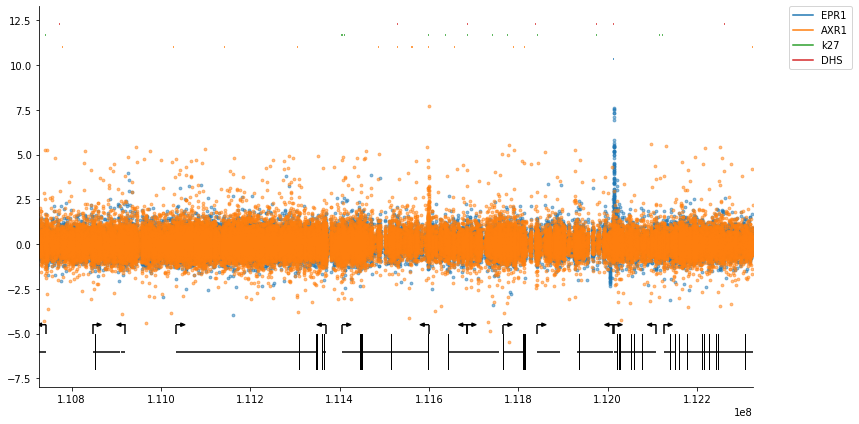

In [12]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['EPR1','AXR1','k27','DHS'], get_chrom='chr12')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

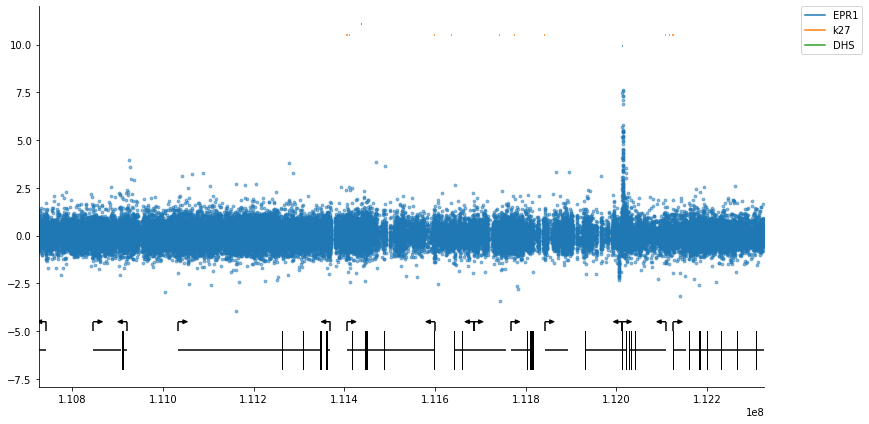

In [13]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'], get_chrom='chr12')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

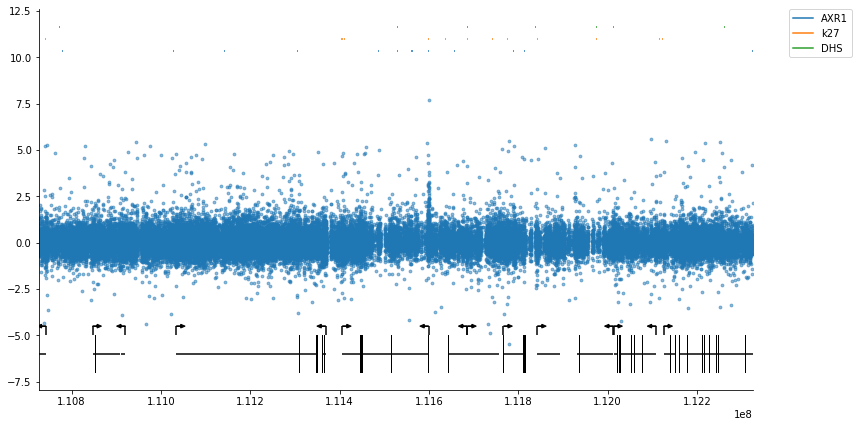

In [14]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['AXR1','k27','DHS'], get_chrom='chr12')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

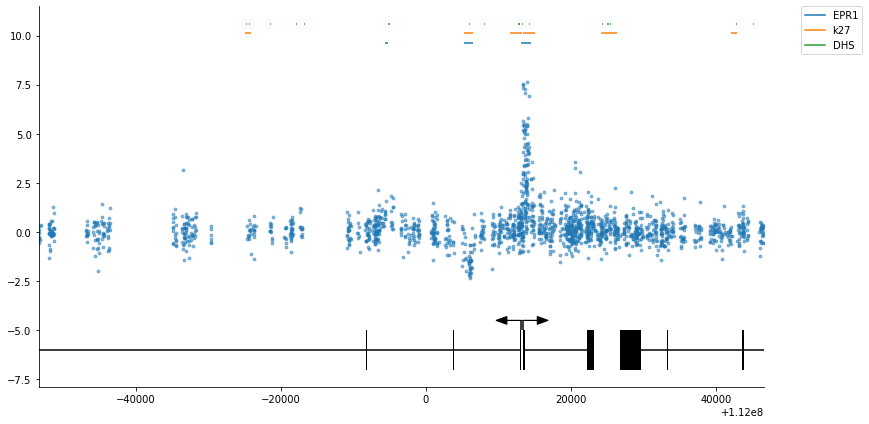

In [15]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

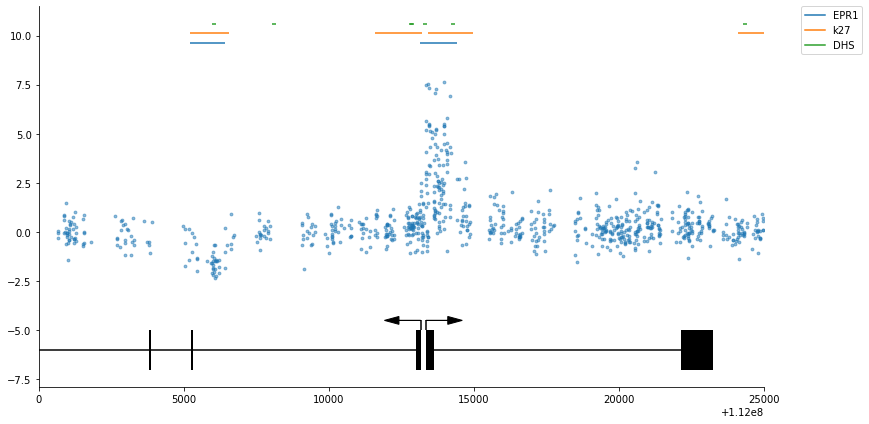

In [16]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

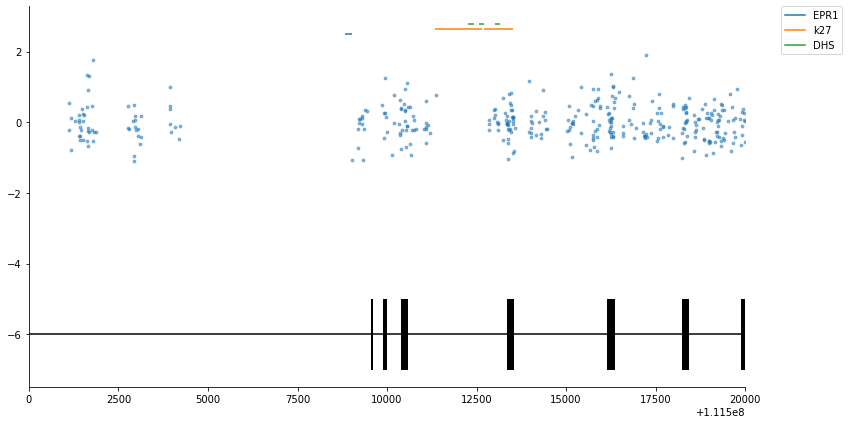

In [17]:
fig_h = plot_hff_cutsites(np.array([[111500000,111520000]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

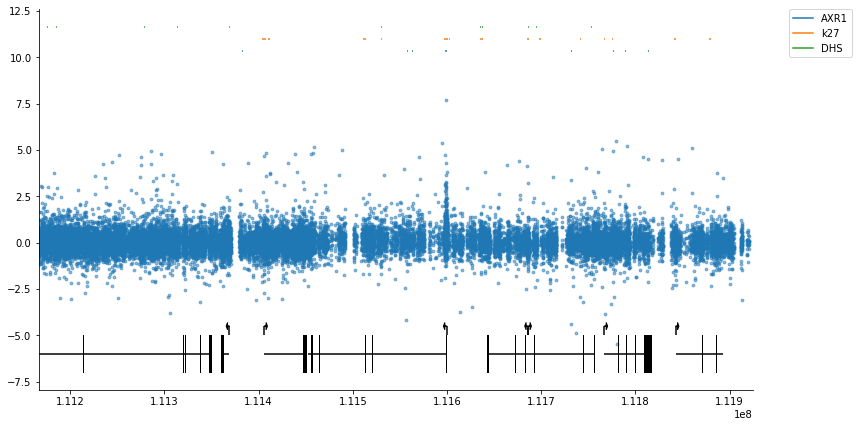

In [18]:
fig_h = plot_hff_cutsites(np.array([[111166560,111924841]]), 
                  data, test_peaks, plot_ids=['AXR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

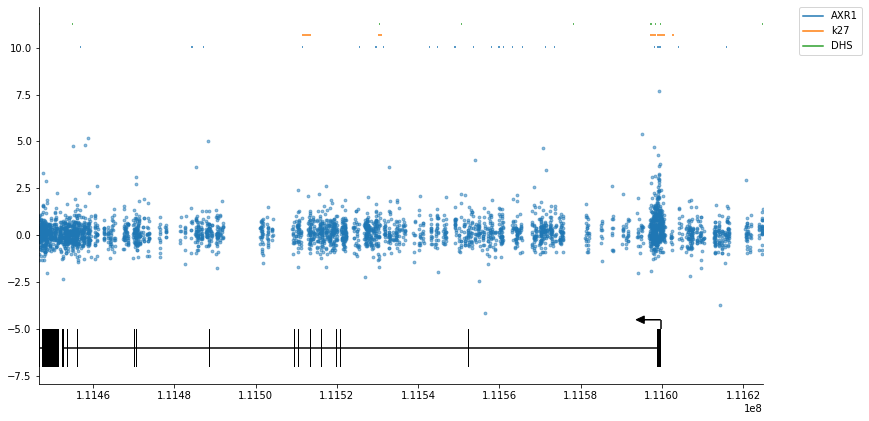

In [19]:
fig_h = plot_hff_cutsites(np.array([[111446560,111624841]]), 
                  data, test_peaks, plot_ids=['AXR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[4000,0.4,2000])

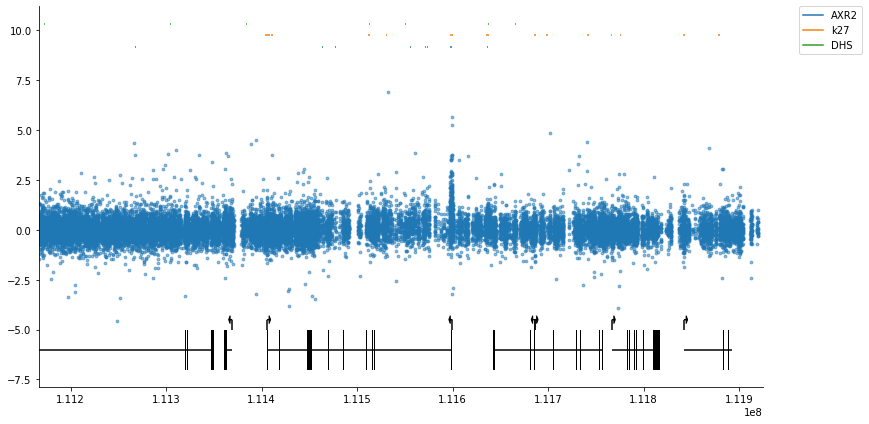

In [20]:
fig_h = plot_hff_cutsites(np.array([[111166560,111924841]]), 
                  data, test_peaks, plot_ids=['AXR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

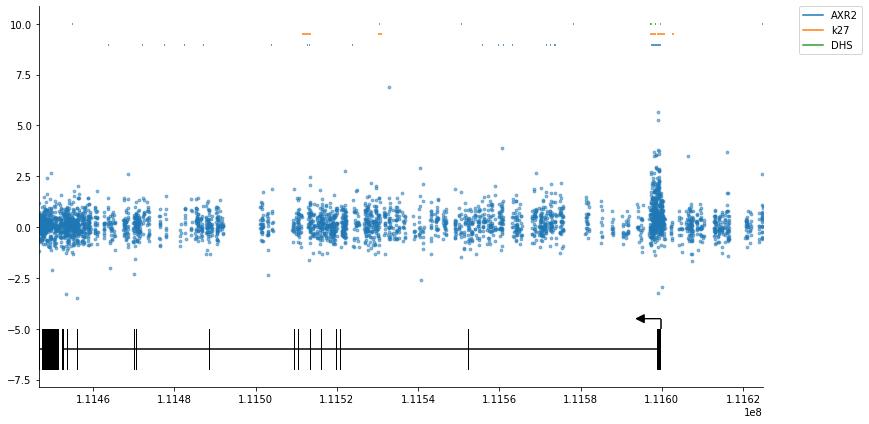

In [21]:
fig_h = plot_hff_cutsites(np.array([[111446560,111624841]]), 
                  data, test_peaks, plot_ids=['AXR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[4000,0.4,2000])

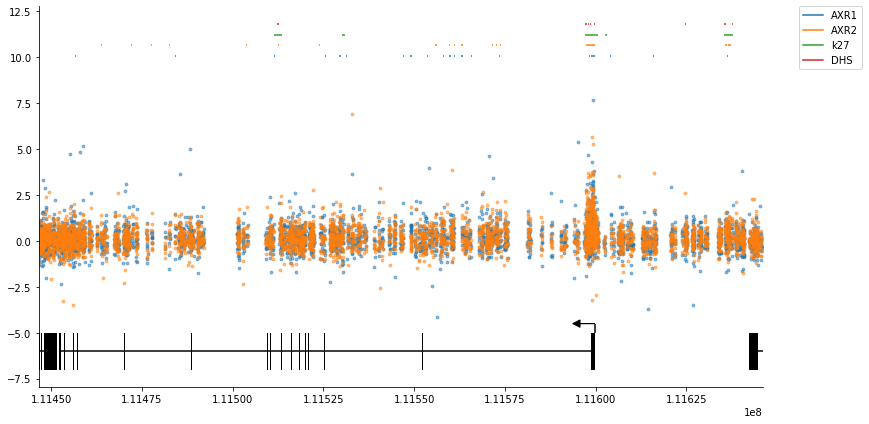

In [22]:
fig_h = plot_hff_cutsites(np.array([[111446560,111646000]]), 
                  data, test_peaks, plot_ids=['AXR1','AXR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[4000,0.4,2000])

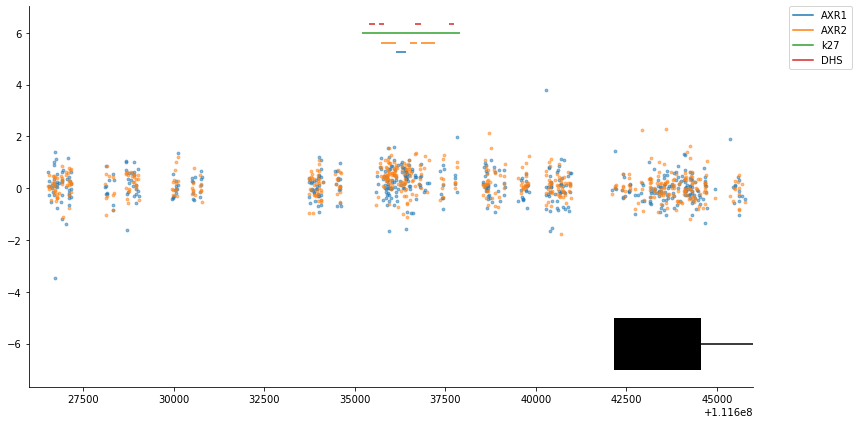

In [23]:
fig_h = plot_hff_cutsites(np.array([[111626000,111646000]]), 
                  data, test_peaks, plot_ids=['AXR1','AXR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[4000,0.4,2000])

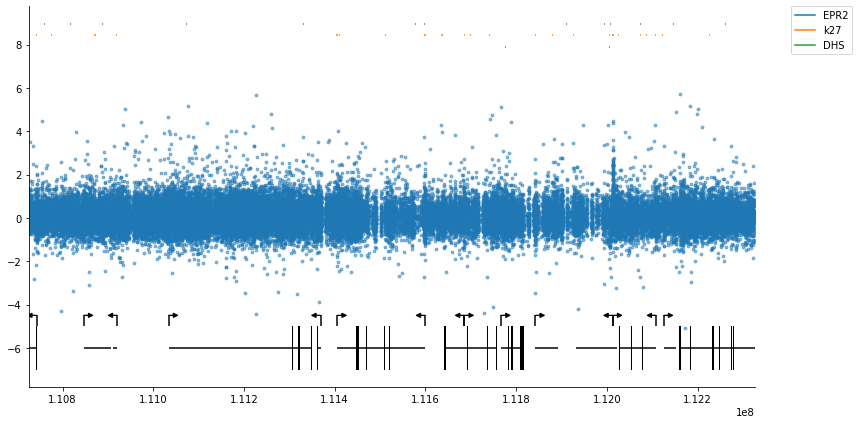

In [24]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

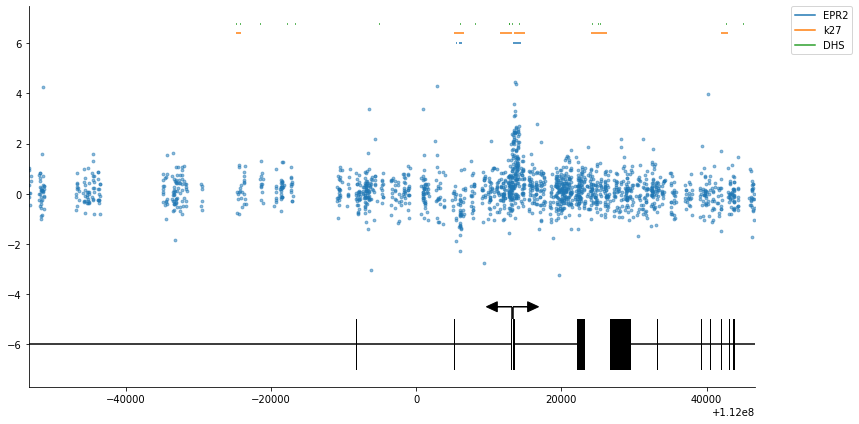

In [25]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

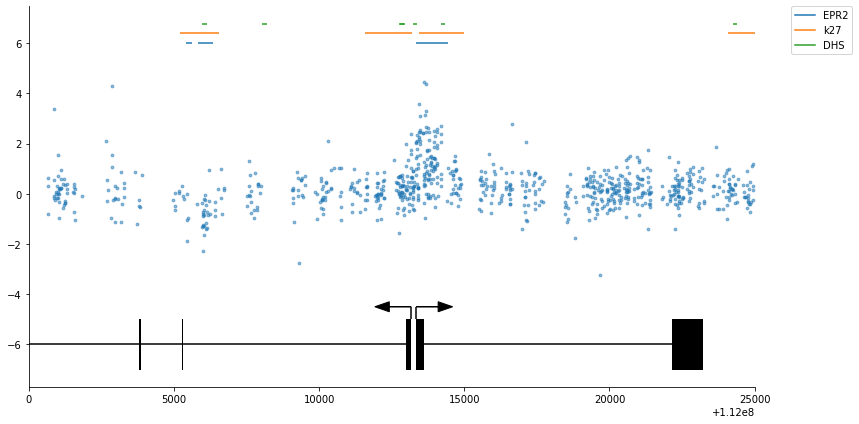

In [26]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

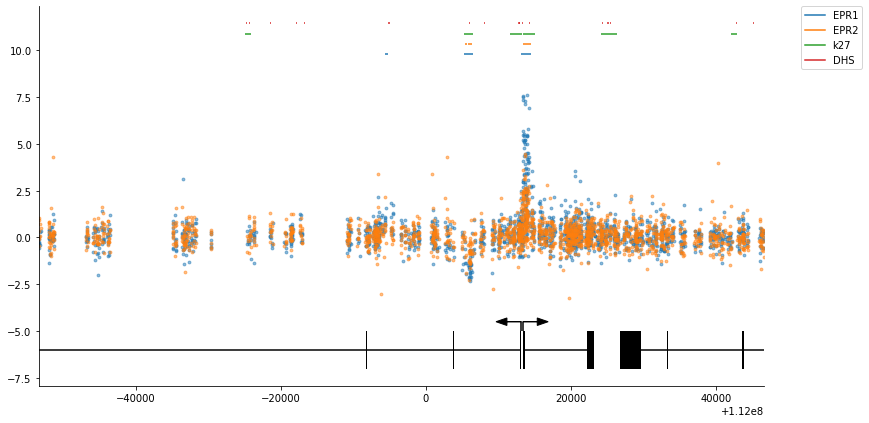

In [27]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

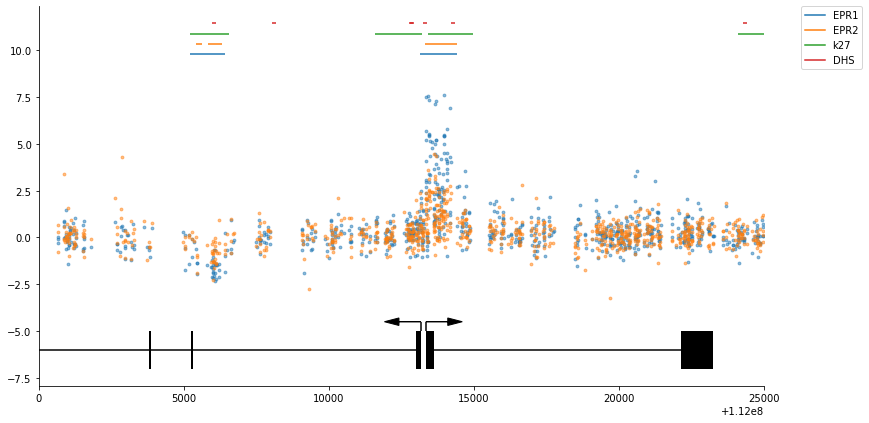

In [28]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

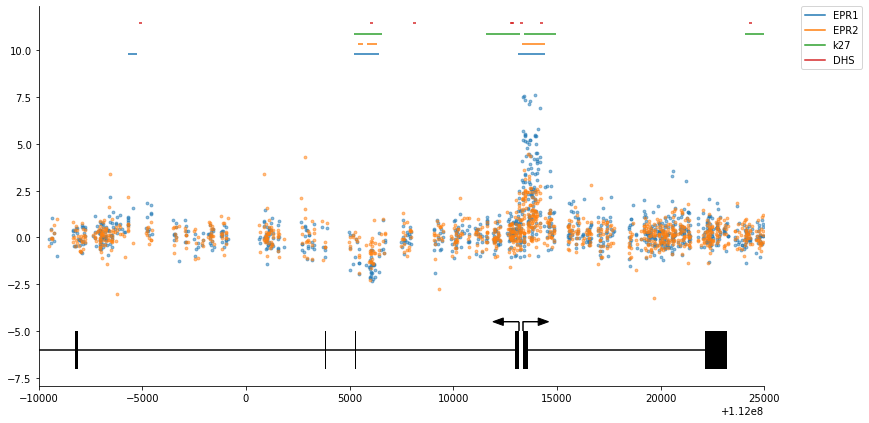

In [29]:
fig_h = plot_hff_cutsites(np.array([[112000000-10000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

ERP29
78
ATXN2
75
SH2B3
35030


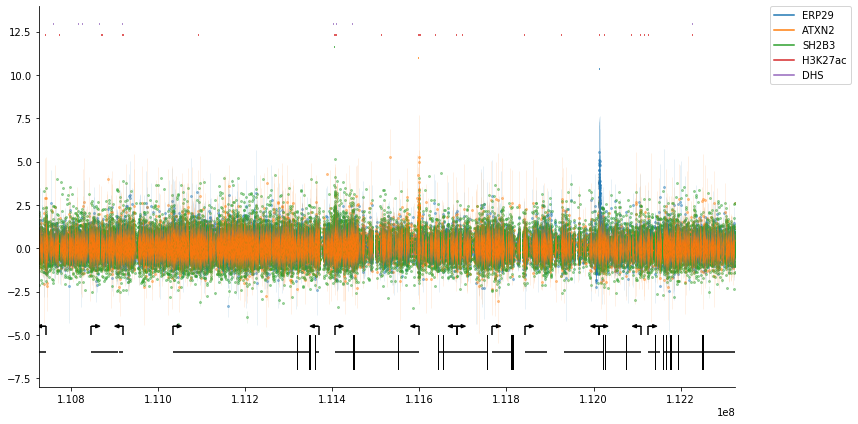

In [30]:
fig_h, ax_h = plot_combined_cutsites(np.array([[110726026,112325903]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','AXR1','AXR2','SHR1','SHR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.2,10000])
fig_h.savefig('ATXN_locus__110726026_112325903__all.pdf')

ERP29
2


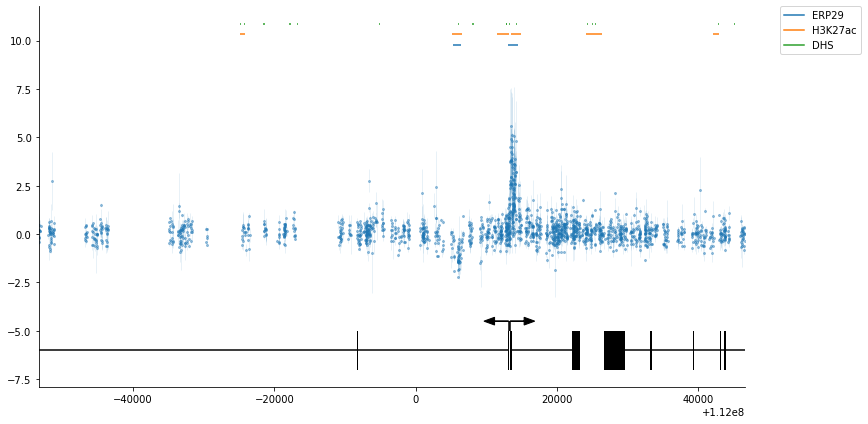

In [31]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111946626,112046626]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[2000,0.4,1500])
fig_h.savefig('ATXN_locus__111946626_112046626__all.pdf')

ERP29
0


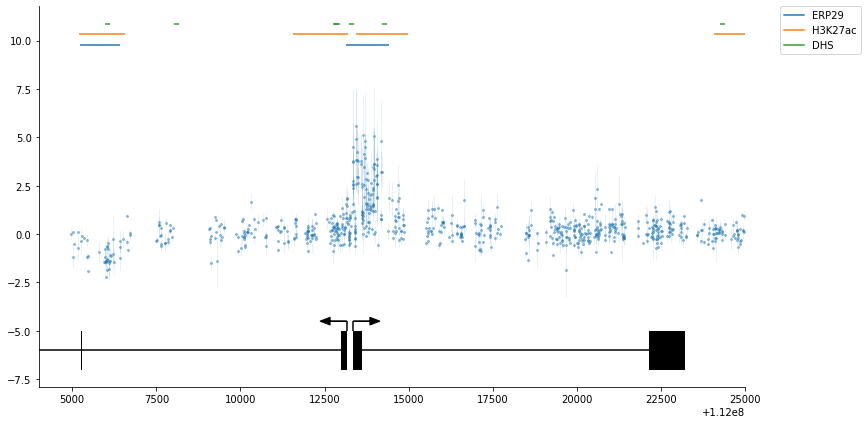

In [32]:
fig_h, ax_h = plot_combined_cutsites(np.array([[112004000,112025000]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__112004000_112025000__all.pdf')

ERP29
2


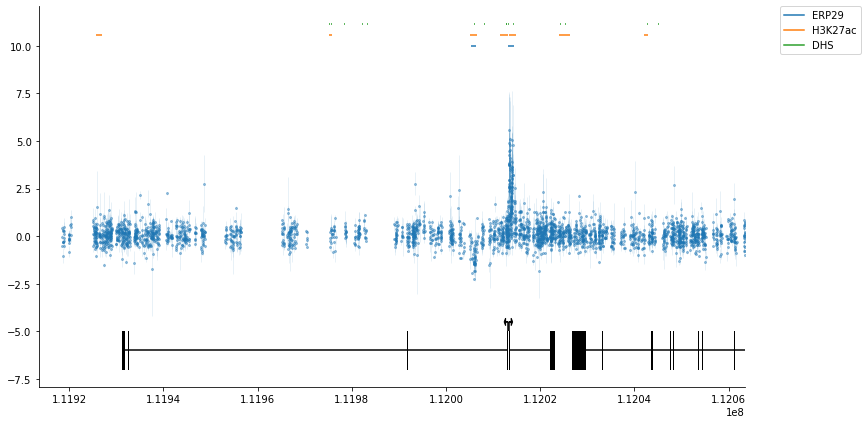

In [33]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111913514,112063514]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__111913514_112063514__all.pdf')

ATXN2
42


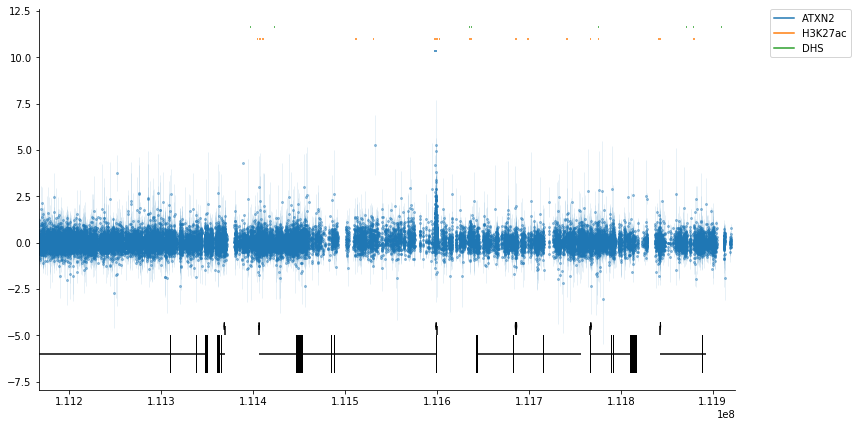

In [34]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111166560,111924841]]), 
          data, test_peaks, plot_ids=['AXR1','AXR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__111166560_111924841__all.pdf')

ATXN2
5


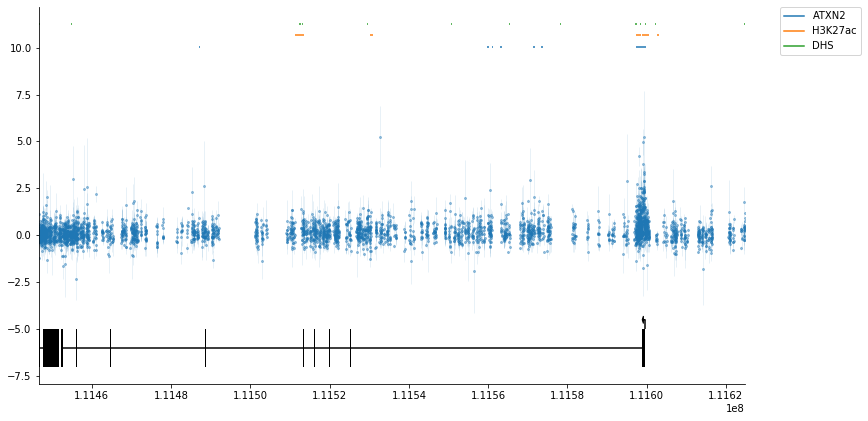

In [35]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111446560,111624841]]), 
          data, test_peaks, plot_ids=['AXR1','AXR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__111446560_111624841__all.pdf')

SH2B3
16382


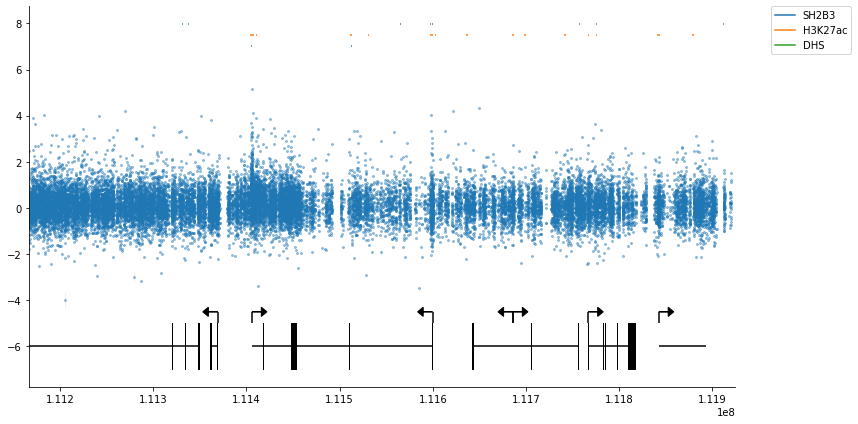

In [36]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111166560,111924841]]), 
          data, test_peaks, plot_ids=['SHR1','SHR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.4,6000])
fig_h.savefig('ATXN_locus__111166560_111924841__all.pdf')

SH2B3
2868


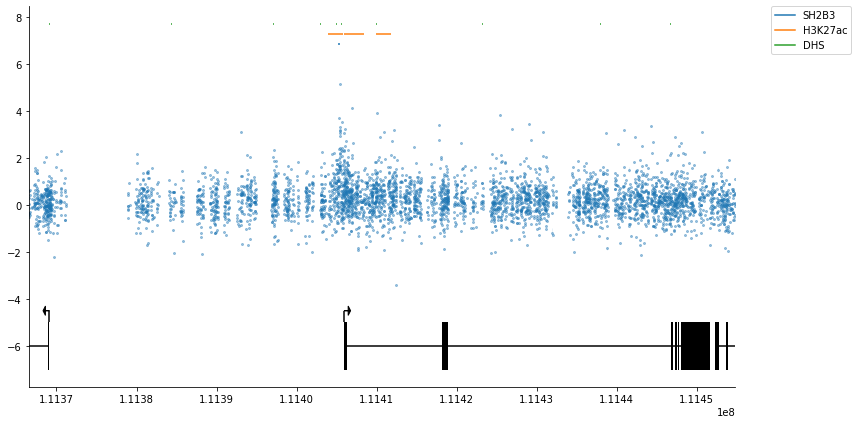

In [37]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111366560,111454841]]), 
          data, test_peaks, plot_ids=['SHR1','SHR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__111366560_111624841__SH2B3.pdf')

# Connection diagram

In [38]:
txn_starts = extract_txn_starts(gff)

In [39]:
all_locus_peaks = get_replicating_peaks(test_peaks)

In [41]:
# ERP29
ERP29_total_scores = get_peak_strengths(EPR1_bed, EPR2_bed)

# ATXN2
ATXN2_total_scores = get_peak_strengths(AXR1_bed, AXR2_bed)

# SH2B3
SH2B3_total_scores = get_peak_strengths(SHR1_bed, SHR2_bed)



../hcr-ff/plot_utils.py:310: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


### Full locus connectogram

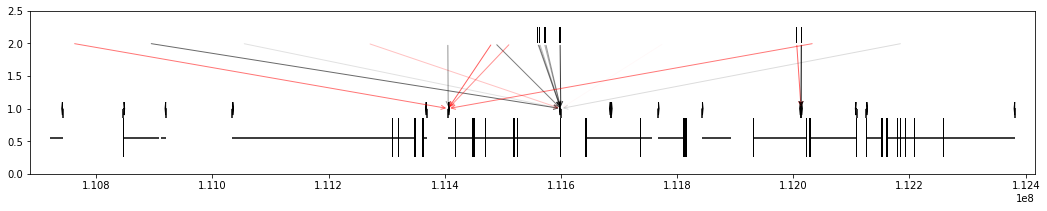

In [42]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = gff_to_locus_lims(gff,0.02)
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ATXN2'], y_anchor=2.0, y_target=1.0, score_bed=ATXN2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['SH2B3'], y_anchor=2.0, y_target=1.0, score_bed=SH2B3_total_scores, xlims=glims)

plt.savefig('ATXN_locus__full_locus__connectogram.pdf')

plt.show()

### Focus on ERP2

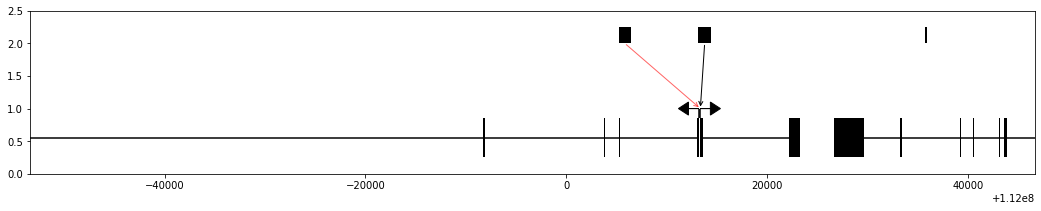

In [43]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111946626,112046626]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores, xlims=glims)

plt.savefig('ATXN_locus__111946626_112046626__connectogram.pdf')

plt.show()

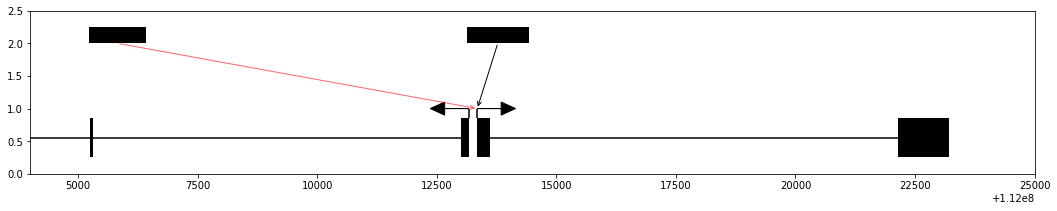

In [44]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [112004000,112025000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,300], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores, xlims=glims)

plt.savefig('ATXN_locus__112004000_112025000__connectogram.pdf')

plt.show()

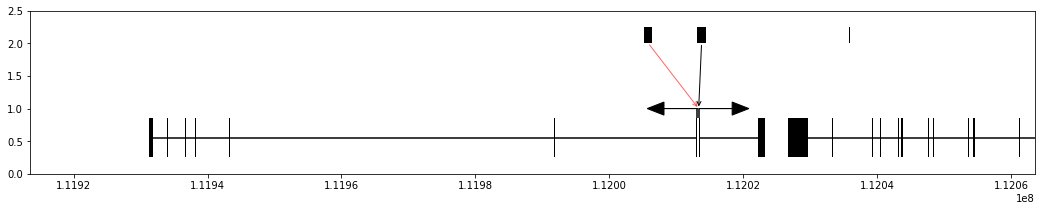

In [45]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111913514,112063514]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[5000,0.2,2500], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores, xlims=glims)

plt.savefig('ATXN_locus__111913514_112063514__connectogram.pdf')

plt.show()

### Focus on ATXN2

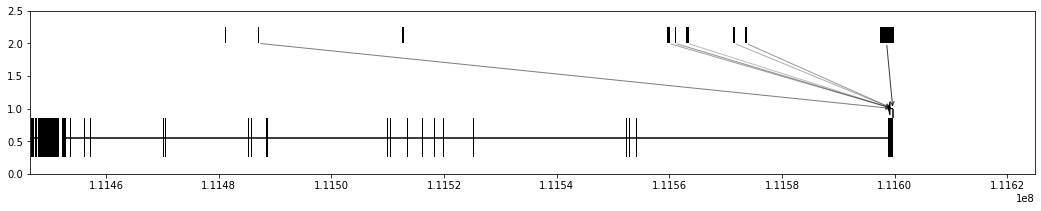

In [46]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111446560,111624841]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,300], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ATXN2'], y_anchor=2.0, y_target=1.0, score_bed=ATXN2_total_scores, xlims=glims)

plt.savefig('ATXN_locus__111446560_111624841__connectogram.pdf')

plt.show()

### Now SH2B3

# Analysis of controls

In [47]:
targ_type = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    rm_zeros = (d_pt['LS_reads'] != 0) & (d_pt['HS_reads'] != 0)
    d_pt = d_pt[rm_zeros].copy()
    d_pt['score'] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    NT_targ = pd.DataFrame({'score': d_pt.loc[~d_pt['Coordinates'].str.contains('chr'),'score'],
                            'coords': d_pt.loc[~d_pt['Coordinates'].str.contains('chr'),'Coordinates'],
                            'target': 'Non',
                            'exp_id': exp_ids[i]})
    
    ET_targ = pd.DataFrame({'score': d_pt.loc[d_pt['Coordinates'].str.contains('chr12'),'score'],
                            'coords': d_pt.loc[d_pt['Coordinates'].str.contains('chr12'),'Coordinates'],
                            'target': 'Experimental',
                            'exp_id': exp_ids[i]})
    
    safe_slice = d_pt['Coordinates'].str.contains('chr') & \
                 (~d_pt['Coordinates'].str.contains('chr12'))
    ST_targ = pd.DataFrame({'score': d_pt.loc[safe_slice,'score'],
                            'coords': d_pt.loc[safe_slice,'Coordinates'],
                            'target': 'Safe',
                            'exp_id': exp_ids[i]})
    
    targ_type.append(pd.concat([NT_targ,ET_targ,ST_targ],axis=0).reset_index(drop=True))
    
targ_type = pd.concat(targ_type,axis=0).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


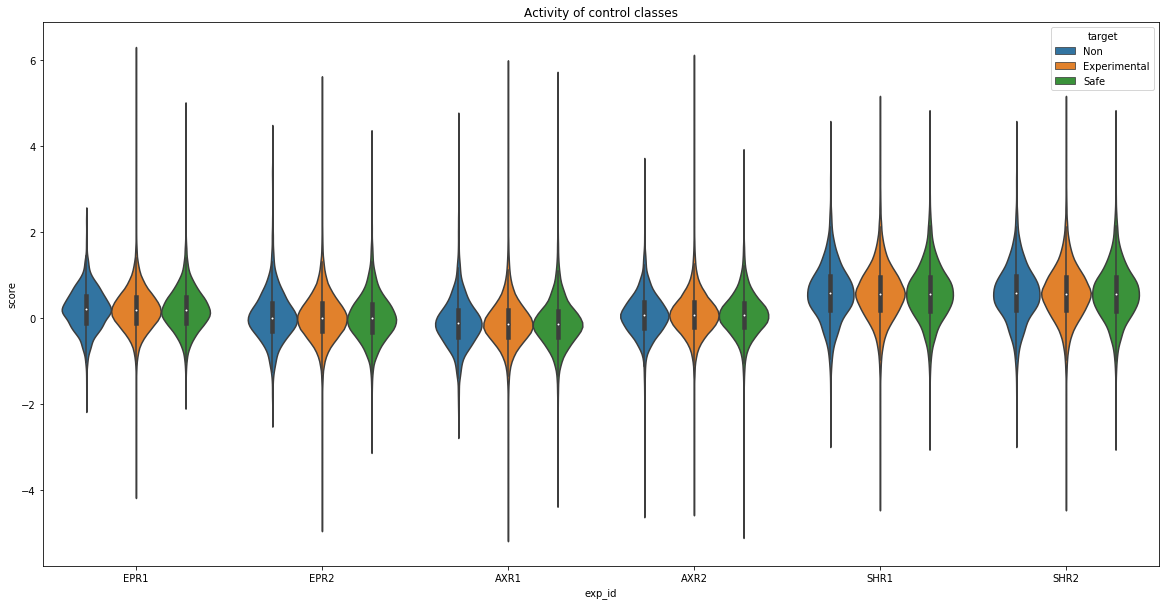

In [48]:
plt.figure(figsize=(20,10))
sns.violinplot(x='exp_id',y='score',hue='target',data=targ_type, showfliers = False) \
  .set_title("Activity of control classes");

plt.savefig('control_activity_distribution.pdf')

In [49]:
from scipy.stats import ttest_ind, f_oneway

for exp_id in exp_ids:
    NT_set = targ_type[ (targ_type['exp_id'] == exp_id) & (targ_type['target'] == 'Non') ]
    ST_set = targ_type[ (targ_type['exp_id'] == exp_id) & (targ_type['target'] == 'Safe') ]
    nt_mean= NT_set['score'].mean()
    nt_var = NT_set['score'].var()
    st_mean= ST_set['score'].mean()
    st_var = ST_set['score'].var()
    t_test = ttest_ind(NT_set['score'],ST_set['score'])
    f_test = f_oneway(NT_set['score'],ST_set['score'])
    print("{}:\n\tmean: {}, {}\n\tvariance: {}, {}\n\tt-test\n\tStatistic:\t{}\n\tp-value:\t{}\n\n\tf-test\n\tStatistic:\t{}\n\tp-value:\t{}\n".format(exp_id, nt_mean, st_mean, nt_var, st_var, t_test[0], t_test[1],f_test[0],f_test[1]))

EPR1:
	mean: 0.20604788912318062, 0.1984111461129659
	variance: 0.24109211396250793, 0.2539202654102734
	t-test
	Statistic:	0.5276265917924412
	p-value:	0.5977741532162708

	f-test
	Statistic:	0.2783898203665063
	p-value:	0.5977741532150792

EPR2:
	mean: 0.05156852452299389, 0.01839132109967418
	variance: 0.366738658610312, 0.32170023574693674
	t-test
	Statistic:	1.9982332295147798
	p-value:	0.0457274693687536

	f-test
	Statistic:	3.992936039537063
	p-value:	0.04572746936894562

AXR1:
	mean: -0.10441766002642043, -0.11059226050639179
	variance: 0.3416471183059827, 0.34907066996823843
	t-test
	Statistic:	0.362735124672361
	p-value:	0.7168129977324773

	f-test
	Statistic:	0.1315767706710723
	p-value:	0.7168129977324506

AXR2:
	mean: 0.07597859969954598, 0.08499849713721916
	variance: 0.2811658300417155, 0.26966017847228385
	t-test
	Statistic:	-0.5985971477596733
	p-value:	0.5494596673803932

	f-test
	Statistic:	0.3583185453060166
	p-value:	0.5494596673801935

SHR1:
	mean: 0.5864725263155